#Team Details :
## CS23MTECH11020 - Suryansh Gautam
## CS23MTECH11008 - V Harikrishnan
## CS23MTECH11029 - Patel Heetkumar D.
## CS23MTECH13001 - Anil kumar Sharma
## CS23MTECH13002 - KR Anuraj


Importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from scipy.optimize import differential_evolution

Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


Reading and preprocessing data

In [ ]:
data_pd=pd.read_csv('costsensitiveregression.csv')
len(data_pd)

147636

In [ ]:
train, test = train_test_split(data_pd, test_size=0.2, random_state=42)


Custom Dataset class to load data from CSV file


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_pd, transform=None):
        self.data = data_pd;
        self.transform=transform

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.tensor(sample[:-2], dtype=torch.float32)
        label = torch.tensor(sample[-2], dtype=torch.long)
        fnc = torch.tensor(sample[-1], dtype=torch.long)
        if self.transform:
            features = self.transform(features)
        return features, label, fnc

In [ ]:
train_dataset = CustomDataset(data_pd)
test_dataset = CustomDataset(test)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)


In [ ]:
nan_values = data_pd.isna().sum()
print(nan_values)

NotCount    0
YesCount    0
ATPM        0
PFD         0
PFG         0
SFD         0
SFG         0
WP          0
WS          0
AH          0
AN          0
Status      0
FNC         0
dtype: int64


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

Linear neural network model

In [ ]:
class LinearNN(nn.Module):
    def __init__(self, input_size):
        super(LinearNN, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.weight) + self.bias)

In [ ]:
CF_P = 6
CT_P = 6
CT_N = 0

# Bahnsen's Approach

In [ ]:
samples = train.iloc[:, :-2]
labels = train.iloc[:, -2]
fncs = train.iloc[:, -1]

features = torch.tensor(samples.values, dtype=torch.float32)
features.to(device)
labels = torch.tensor(labels.values, dtype=torch.long)
fncs = torch.tensor(fncs.values, dtype=torch.long)

In [ ]:
features[1:10]

tensor([[1.4000e+01, 9.0000e+00, 7.0889e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0889e-02],
        [8.0000e+00, 1.5000e+01, 1.4023e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.3259e+00, 0.0000e+00, 0.0000e+00],
        [1.8000e+01, 4.0000e+00, 1.7340e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.1000e+01, 1.3670e-01, 0.0000e+00, 5.8800e-03, 0.0000e+00,
         6.4040e-02, 8.8055e-02, 4.5608e-02, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 2.0000e+01, 3.5181e-02, 0.0000e+00, 6.2312e-01, 0.0000e+00,
         0.0000e+00, 1.3131e+00, 2.2696e-01, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.2000e+01, 4.3400e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3400e-04],
        [0.0000e+00, 2.2000e+01, 2.0254e-02, 0.0000e+00, 1.4158e-01, 0.0000e+00,
         3.05

In [ ]:
def logistic_regression_accuracy(weights):
    model = LinearNN(11)

    with torch.no_grad():
        weight_tensor = torch.tensor(weights[:-1], dtype=torch.float32)
        bias_tensor = torch.tensor([weights[-1]], dtype=torch.float32)
        model.weight = nn.Parameter(weight_tensor.view_as(model.weight))
        model.bias = nn.Parameter(bias_tensor)

    model.eval()
    y_pred_probs = model(features)
    loss = (labels * (y_pred_probs * 6 + (1 - y_pred_probs) * fncs)).sum() + ((1 - labels) * (y_pred_probs * 6)).sum()

    loss / y_pred_probs.size(0)
    print(loss / y_pred_probs.size(0))
    return (loss / y_pred_probs.size(0)).detach()

In [ ]:
print(len(train_loader.dataset))

147636


In [ ]:
bounds = [(-1e5, 1e5) for _ in range(12)]
result = differential_evolution(logistic_regression_accuracy, bounds)
optimal_weights = result.x



Streaming output truncated to the last 5000 lines.
tensor(10.5492, grad_fn=<DivBackward0>)
tensor(16.6763, grad_fn=<DivBackward0>)
tensor(7.0032, grad_fn=<DivBackward0>)
tensor(13.3003, grad_fn=<DivBackward0>)
tensor(6.4257, grad_fn=<DivBackward0>)
tensor(4.7063, grad_fn=<DivBackward0>)
tensor(3.6351, grad_fn=<DivBackward0>)
tensor(9.2954, grad_fn=<DivBackward0>)
tensor(3.7026, grad_fn=<DivBackward0>)
tensor(11.8290, grad_fn=<DivBackward0>)
tensor(12.3725, grad_fn=<DivBackward0>)
tensor(3.5781, grad_fn=<DivBackward0>)
tensor(3.6662, grad_fn=<DivBackward0>)
tensor(3.4483, grad_fn=<DivBackward0>)
tensor(3.5072, grad_fn=<DivBackward0>)
tensor(3.7614, grad_fn=<DivBackward0>)
tensor(8.1563, grad_fn=<DivBackward0>)
tensor(13.4097, grad_fn=<DivBackward0>)
tensor(6.5935, grad_fn=<DivBackward0>)
tensor(8.1796, grad_fn=<DivBackward0>)
tensor(3.4882, grad_fn=<DivBackward0>)
tensor(7.5280, grad_fn=<DivBackward0>)
tensor(3.6986, grad_fn=<DivBackward0>)
tensor(4.1857, grad_fn=<DivBackward0>)
tensor(

Create the final logistic regression model with the optimal parameters


In [ ]:
final_model = LinearNN(11)
with torch.no_grad():
        weight_tensor = torch.tensor(optimal_weights[:-1], dtype=torch.float32)
        bias_tensor = torch.tensor([optimal_weights[-1]], dtype=torch.float32)
        final_model.weight = nn.Parameter(weight_tensor.view_as(final_model.weight))
        final_model.bias = nn.Parameter(bias_tensor)

y_pred_probs = final_model(features)
final_accuracy = accuracy_score(labels.detach().numpy(), torch.round(y_pred_probs).detach().numpy())
print("Optimal Accuracy:", final_accuracy)


Optimal Accuracy: 0.7668913198089884


Plotting the confusion matrix

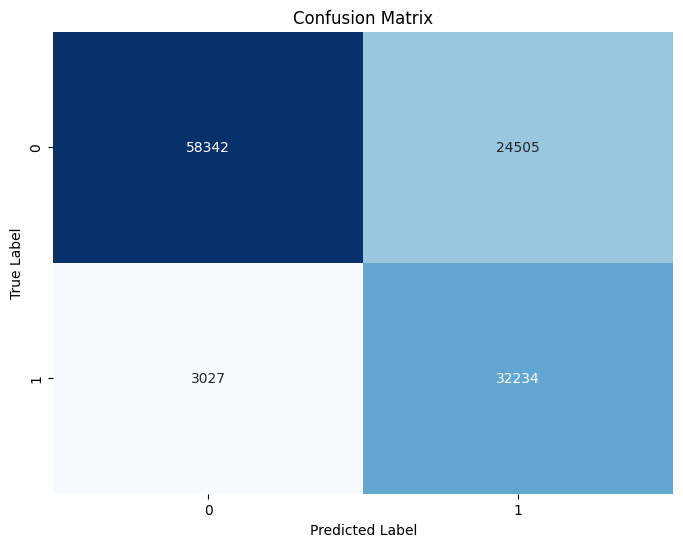

In [ ]:
predicted_labels = torch.round(y_pred_probs).detach().numpy()
ground_truth_labels = labels.detach().numpy()

cm = confusion_matrix(ground_truth_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Nikou Gunnemann's Approach

In [ ]:
def logistic_regression_accuracy2(weights):
    model = LinearNN(11)
    with torch.no_grad():
        weight_tensor = torch.tensor(weights[:-1], dtype=torch.float32)
        bias_tensor = torch.tensor([weights[-1]], dtype=torch.float32)
        model.weight = nn.Parameter(weight_tensor.view_as(model.weight))
        model.bias = nn.Parameter(bias_tensor)
    model.eval()
    epsilon = 1e-9

    y_pred_probs = model(features)
    loss = (labels * (-torch.log(y_pred_probs + epsilon) * 6 + (-torch.log(1 - y_pred_probs+epsilon)) * fncs)).sum() + \
       ((1 - labels) * (-torch.log(y_pred_probs + epsilon) * 6)).sum()

    loss / y_pred_probs.size(0)
    print(loss / y_pred_probs.size(0))
    return (loss / y_pred_probs.size(0)).detach()

In [ ]:
bounds = [(-1, 1) for _ in range(12)]
result = differential_evolution(logistic_regression_accuracy2, bounds)
optimal_weights = result.x

Streaming output truncated to the last 5000 lines.
tensor(65.2363, grad_fn=<DivBackward0>)
tensor(20.4341, grad_fn=<DivBackward0>)
tensor(23.2636, grad_fn=<DivBackward0>)
tensor(73.2578, grad_fn=<DivBackward0>)
tensor(15.6034, grad_fn=<DivBackward0>)
tensor(48.4151, grad_fn=<DivBackward0>)
tensor(39.1185, grad_fn=<DivBackward0>)
tensor(23.8001, grad_fn=<DivBackward0>)
tensor(34.9356, grad_fn=<DivBackward0>)
tensor(24.7602, grad_fn=<DivBackward0>)
tensor(16.6270, grad_fn=<DivBackward0>)
tensor(25.8898, grad_fn=<DivBackward0>)
tensor(18.6638, grad_fn=<DivBackward0>)
tensor(33.6559, grad_fn=<DivBackward0>)
tensor(36.9645, grad_fn=<DivBackward0>)
tensor(41.1004, grad_fn=<DivBackward0>)
tensor(29.1348, grad_fn=<DivBackward0>)
tensor(35.6621, grad_fn=<DivBackward0>)
tensor(24.5506, grad_fn=<DivBackward0>)
tensor(18.0308, grad_fn=<DivBackward0>)
tensor(19.5704, grad_fn=<DivBackward0>)
tensor(16.1330, grad_fn=<DivBackward0>)
tensor(19.4767, grad_fn=<DivBackward0>)
tensor(151.4686, grad_fn=<Div

In [ ]:
final_model = LinearNN(11)
with torch.no_grad():
        weight_tensor = torch.tensor(optimal_weights[:-1], dtype=torch.float32)
        bias_tensor = torch.tensor([optimal_weights[-1]], dtype=torch.float32)
        final_model.weight = nn.Parameter(weight_tensor.view_as(final_model.weight))
        final_model.bias = nn.Parameter(bias_tensor)

y_pred_probs = final_model(features)
final_accuracy = accuracy_score(labels.detach().numpy(), torch.round(y_pred_probs).detach().numpy())
print("Optimal Accuracy:", final_accuracy)

Optimal Accuracy: 0.3499762928844786


Plotting the confusion matrix

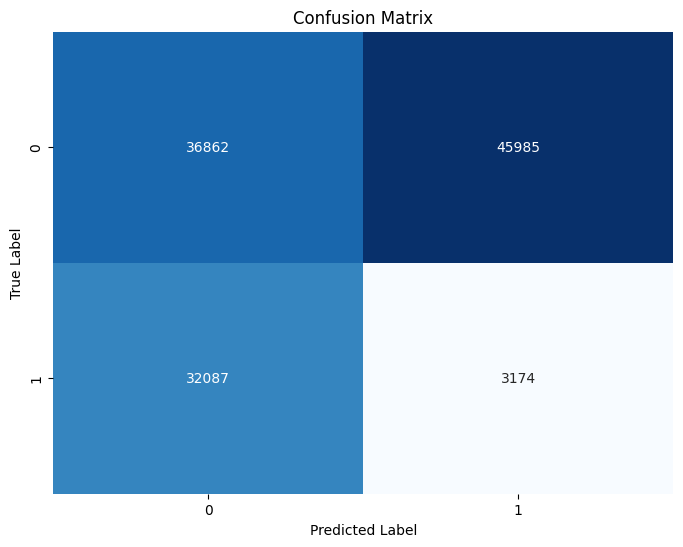

In [ ]:
predicted_labels = torch.round(y_pred_probs).detach().numpy()
ground_truth_labels = labels.detach().numpy()
cm = confusion_matrix(ground_truth_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()